<a href="https://colab.research.google.com/github/LeonGoergen/informationExtraction/blob/main/qa/legal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
device = cuda.get_current_device()
device.reset()

## Installations

In [ ]:
!pip install datasets
!pip install evaluate
!pip install seqeval
!pip install transformers[torch]
!pip install numba

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=bc46ba5f23c7a9b7a787549c786c12a8a602b49635b75d3153859be879ecb249
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
exit(0)

## Imports

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, Trainer, TrainingArguments, pipeline, DefaultDataCollator
import datasets
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from collections import Counter, defaultdict
import torch
from numba import cuda
import os
import string
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
train = pd.read_json('/content/drive/MyDrive/Masterarbeit/Datasets/train.json')
test = pd.read_json('/content/drive/MyDrive/Masterarbeit/Datasets/test.json')

len(train), len(test)

(17946, 3167)

## Classes

In [ ]:
class ModelTrainer():
  def __init__(self, model_name, tokenizer_name):
    self.model = AutoModelForQuestionAnswering.from_pretrained(model_name)
    self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    if self.tokenizer.pad_token is None:
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.resize_token_embeddings(len(self.tokenizer))

    self.data_collator = DefaultDataCollator()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model.to(device)

  def train(self, df, training_args):
    self.__prepare_data(df)

    self.trainer = Trainer(
      model=self.model,
      args=training_args,
      train_dataset=self.tokenized_train,
      eval_dataset=self.tokenized_eval,
      tokenizer=self.tokenizer,
      data_collator=self.data_collator,
    )

    self.trainer.train()

  def save(self, name):
    self.trainer.save_model("/content/" + name + "/final")
    zip_command = f'zip -r "/content/drive/MyDrive/Masterarbeit/Models/qa_{name}.zip" "/content/{name}/final"'
    !{zip_command}

  def evaluate_training(self):
    train_losses = []
    eval_losses = []

    for d in self.trainer.state.log_history:
        if "loss" in d:
          train_losses.append(d["loss"])
        elif "eval_loss" in d:
          eval_losses.append(d["eval_loss"])

    plt.plot(train_losses, label='train')
    plt.plot(eval_losses, label='eval')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show();

  def __prepare_data(self, df):
    qa_pairs_list = df['qa_pairs']
    expanded_entries = []

    for qa_pairs in qa_pairs_list:
      for qa_pair in qa_pairs:
        for start, text in zip(qa_pair['answers']['answer_start'], qa_pair['answers']['text']):
          new_entry = {
            'id': qa_pair['id'],
            'tag': qa_pair['tag'],
            'answers': {'answer_start': [start], 'text': [text]},
            'context': qa_pair['context'],
            'question': qa_pair['question']
          }
          expanded_entries.append(new_entry)

    qa_df = pd.DataFrame(expanded_entries)
    df_train, df_eval = train_test_split(qa_df, test_size=0.2, random_state=42)

    train_hugging = Dataset.from_pandas(df_train)
    eval_hugging = Dataset.from_pandas(df_eval)

    self.tokenized_train = train_hugging.map(self.__preprocess_function, batched=True, remove_columns=train_hugging.column_names)
    self.tokenized_eval = eval_hugging.map(self.__preprocess_function, batched=True, remove_columns=eval_hugging.column_names)

  def __preprocess_function(self, examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = self.tokenizer(
        questions,
        examples["context"],
        max_length=512,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
class ModelPipe:
    def __init__(self, model_name, tokenizer_name):
        self.model_name = model_name
        self.tokenizer_name = tokenizer_name
        self._prepare_environment()
        self._load_model_and_tokenizer()
        self._initialize_pipeline()

    def _prepare_environment(self):
        model_dir = f"/content/{self.model_name}/final"
        if os.path.exists(model_dir):
            os.system(f'rm -rf "{model_dir}"')
        os.makedirs(model_dir, exist_ok=True)

        zip_path = f"/content/drive/MyDrive/Masterarbeit/Models/qa_{self.model_name}.zip"
        os.system(f'unzip "{zip_path}" -d "{model_dir}"')

    def _load_model_and_tokenizer(self):
        model_path = f"/content/{self.model_name}/final/content/{self.model_name}/final"
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)

    def _initialize_pipeline(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.pipe = pipeline("question-answering", model=self.model, tokenizer=self.tokenizer, device=0)

    def inference(self, question, context):
        return self.pipe(question=question, context=context)

    def evaluate(self, df):
        self.pred_data = []

        for idx, example in tqdm(df.iterrows(), total=df.shape[0]):
            for qa_pair in example['qa_pairs']:
                question = qa_pair['question']
                context = qa_pair['context']
                answer = qa_pair['answers']['text'][0]
                prediction = self.inference(question, context)

                self.pred_data.append({
                    'entity_type': qa_pair['tag'],
                    'answer': answer,
                    'model_prediction': prediction['answer']
                })

    def print_classification_report(self):
        entity_metrics = defaultdict(lambda: {'precision': 0, 'recall': 0, 'f1': 0, 'exact_match': 0, 'support': 0})
        total_counts = {'true_positives': 0, 'false_positives': 0, 'false_negatives': 0, 'exact_matches': 0, 'total': 0}
        entity_support = defaultdict(int)

        for entry in self.pred_data:
            self._update_metrics(entry, entity_metrics, total_counts, entity_support)

        metrics_summary = self._calculate_metrics(entity_metrics, total_counts, entity_support)
        table_data = self._prepare_table_data(entity_metrics, metrics_summary)

        print(tabulate(table_data, headers=["", "precision", "recall", "f1", "exact_match", "support"]))

    def _normalize_text(self, s):
        s = s.lower().strip()
        s = ''.join(ch for ch in s if ch not in string.punctuation)
        s = ' '.join(s.split())
        return s

    def _compute_exact_match(self, prediction, truth):
        return int(self._normalize_text(prediction) == self._normalize_text(truth))

    def _compute_metrics(self, prediction, truth):
        pred_tokens = self._normalize_text(prediction).split()
        truth_tokens = self._normalize_text(truth).split()

        if not pred_tokens or not truth_tokens:
            return int(pred_tokens == truth_tokens), int(pred_tokens == truth_tokens), int(pred_tokens == truth_tokens)

        common_tokens = set(pred_tokens) & set(truth_tokens)

        if not common_tokens:
            return 0, 0, 0

        prec = len(common_tokens) / len(pred_tokens)
        rec = len(common_tokens) / len(truth_tokens)
        f1 = 2 * (prec * rec) / (prec + rec)

        return prec, rec, f1

    def _update_metrics(self, entry, entity_metrics, total_counts, entity_support):
        entity_type = entry['entity_type']
        answer = entry['answer']
        model_prediction = entry['model_prediction']

        exact_match = self._compute_exact_match(model_prediction, answer)
        precision, recall, f1 = self._compute_metrics(model_prediction, answer)

        entity_metrics[entity_type]['precision'] += precision
        entity_metrics[entity_type]['recall'] += recall
        entity_metrics[entity_type]['f1'] += f1
        entity_metrics[entity_type]['exact_match'] += exact_match
        entity_metrics[entity_type]['support'] += 1

        total_counts['true_positives'] += exact_match
        total_counts['false_positives'] += int(precision == 0 and not exact_match)
        total_counts['false_negatives'] += int(recall == 0 and not exact_match)
        total_counts['exact_matches'] += exact_match
        total_counts['total'] += 1

        entity_support[entity_type] += 1

    def _calculate_metrics(self, entity_metrics, total_counts, entity_support):
        def safe_divide(numerator, denominator):
            return numerator / denominator if denominator > 0 else 0

        for metrics in entity_metrics.values():
            if metrics['support']:
                metrics['precision'] /= metrics['support']
                metrics['recall'] /= metrics['support']
                metrics['f1'] /= metrics['support']
                metrics['exact_match'] /= metrics['support']

        support = total_counts['total']

        micro_prec = safe_divide(total_counts['true_positives'], total_counts['true_positives'] + total_counts['false_positives'])
        micro_rec = safe_divide(total_counts['true_positives'], total_counts['true_positives'] + total_counts['false_negatives'])
        micro_f1 = 2 * (micro_prec * micro_rec) / (micro_prec + micro_rec) if (micro_prec + micro_rec) > 0 else 0
        micro_em = safe_divide(total_counts['exact_matches'], total_counts['total'])

        macro_prec = safe_divide(sum(metrics['precision'] for metrics in entity_metrics.values()), len(entity_metrics))
        macro_rec = safe_divide(sum(metrics['recall'] for metrics in entity_metrics.values()), len(entity_metrics))
        macro_f1 = safe_divide(sum(metrics['f1'] for metrics in entity_metrics.values()), len(entity_metrics))
        macro_em = safe_divide(sum(metrics['exact_match'] for metrics in entity_metrics.values()), len(entity_metrics))

        weighted_prec = safe_divide(sum(entity_support[et] * metrics['precision'] for et, metrics in entity_metrics.items()), sum(entity_support.values()))
        weighted_rec = safe_divide(sum(entity_support[et] * metrics['recall'] for et, metrics in entity_metrics.items()), sum(entity_support.values()))
        weighted_f1 = safe_divide(sum(entity_support[et] * metrics['f1'] for et, metrics in entity_metrics.items()), sum(entity_support.values()))
        weighted_em = safe_divide(sum(entity_support[et] * metrics['exact_match'] for et, metrics in entity_metrics.items()), sum(entity_support.values()))

        return {
            'micro': [round(micro_prec, 3), round(micro_rec, 3), round(micro_f1, 3), round(micro_em, 3), support],
            'macro': [round(macro_prec, 3), round(macro_rec, 3), round(macro_f1, 3), round(macro_em, 3), support],
            'weighted': [round(weighted_prec, 3), round(weighted_rec, 3), round(weighted_f1, 3), round(weighted_em, 3), support]
        }

    def _prepare_table_data(self, entity_metrics, metrics_summary):
        table_data = [
            [entity_type] + [f"{metrics['precision']:.3f}", f"{metrics['recall']:.3f}", f"{metrics['f1']:.3f}", f"{metrics['exact_match']:.3f}", metrics['support']]
            for entity_type, metrics in entity_metrics.items()
        ]
        table_data.append(["", "", "", "", "", ""])
        table_data.extend([
            ["micro_avg"] + [f"{x}" for x in metrics_summary['micro']],
            ["macro_avg"] + [f"{x}" for x in metrics_summary['macro']],
            ["weighted_avg"] + [f"{x}" for x in metrics_summary['weighted']]
        ])
        return table_data

# BERT

In [ ]:
model_name = "deepset-bert-base-cased"

## Training

In [ ]:
model = ModelTrainer("deepset/bert-base-cased-squad2", "deepset/bert-base-cased-squad2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__preprocess_function of <__main__.ModelTrainer object at 0x79d1575ca9b0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subseque

Map:   0%|          | 0/17200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.264524
2,0.397300,0.221156
3,0.397300,0.219195


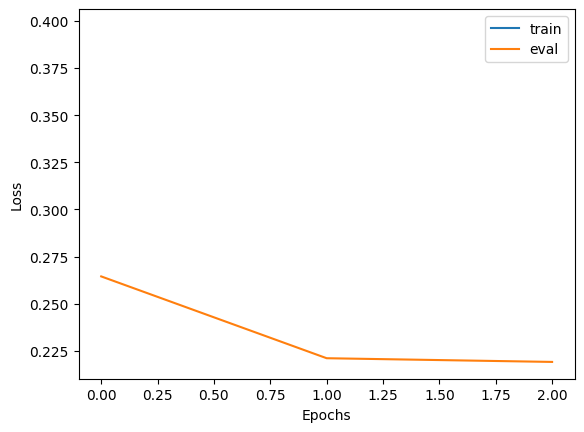

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

updating: content/deepset-bert-base-cased/final/ (stored 0%)
updating: content/deepset-bert-base-cased/final/tokenizer.json (deflated 70%)
updating: content/deepset-bert-base-cased/final/vocab.txt (deflated 49%)
updating: content/deepset-bert-base-cased/final/training_args.bin (deflated 51%)
updating: content/deepset-bert-base-cased/final/config.json (deflated 49%)
updating: content/deepset-bert-base-cased/final/tokenizer_config.json (deflated 76%)
updating: content/deepset-bert-base-cased/final/model.safetensors (deflated 7%)
updating: content/deepset-bert-base-cased/final/special_tokens_map.json (deflated 42%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, "deepset/bert-base-cased-squad2")

In [ ]:
context = test['qa_pairs'][0][0]['context']
question = test['qa_pairs'][0][0]['question']
answer = test['qa_pairs'][0][0]['answers']['text'][0]

print(context)
print(question)
print(answer)
print(pipe.inference(question, context))

( 3 ) Anhaltspunkte dafür , dass der Teilwert der streitbefangenen Wiederbepflanzungsrechte zum 30. Juni 2011 unter deren Anschaffungskosten ( § 6 Abs. 1 Nr. 2 Satz 2 EStG ) gesunken war , sind weder vorgetragen noch ersichtlich .
Was ist der Name des erwähnten Gesetzes?
§ 6 Abs. 1 Nr. 2 Satz 2 EStG
{'score': 1.8943072063848376e-05, 'start': 143, 'end': 164, 'answer': '§ 6 Abs. 1 Nr. 2 Satz'}


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:10<00:00, 44.73it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall    f1     exact_match    support
------------  -----------  --------  -----  -------------  ---------
GS            0.959        0.884     0.902  0.850          1294
LIT           0.953        0.478     0.548  0.342          155
INN           0.992        0.853     0.889  0.751          185
VS            0.834        0.722     0.750  0.522          69
UN            0.949        0.929     0.935  0.910          78
PER           0.959        0.955     0.953  0.930          158
LD            0.977        0.991     0.981  0.965          114
RS            0.914        0.273     0.350  0.114          667
VT            0.940        0.810     0.831  0.686          223
RR            0.995        0.995     0.995  0.995          187
EUN           0.928        0.740     0.777  0.620          100
ST            0.975        0.984     0.978  0.967          61
GRT           0.977        0.969     0.968  0.938          257
LDS           0.691        0.765     0.710  0.6

# RoBERTa

In [ ]:
model_name = "deepset-roberta-base"

## Training

In [ ]:
model = ModelTrainer("deepset/roberta-base-squad2", "deepset/roberta-base-squad2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__preprocess_function of <__main__.ModelTrainer object at 0x7f47b83865f0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subseque

Map:   0%|          | 0/17200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,0.431100,0.221709
2,0.129900,0.192889


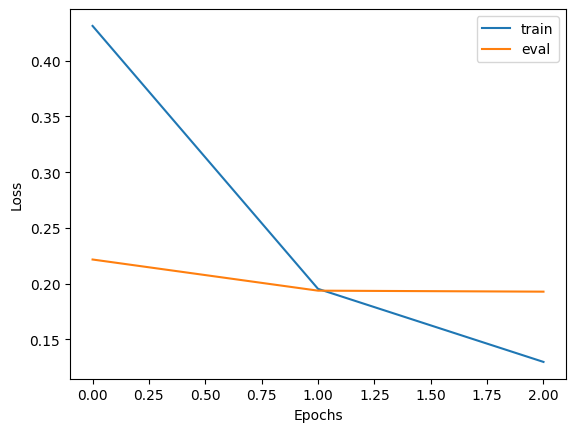

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/deepset-roberta-base/final/ (stored 0%)
  adding: content/deepset-roberta-base/final/merges.txt (deflated 53%)
  adding: content/deepset-roberta-base/final/tokenizer.json (deflated 72%)
  adding: content/deepset-roberta-base/final/vocab.json (deflated 59%)
  adding: content/deepset-roberta-base/final/special_tokens_map.json (deflated 85%)
  adding: content/deepset-roberta-base/final/model.safetensors (deflated 8%)
  adding: content/deepset-roberta-base/final/training_args.bin (deflated 51%)
  adding: content/deepset-roberta-base/final/tokenizer_config.json (deflated 75%)
  adding: content/deepset-roberta-base/final/config.json (deflated 49%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, "deepset/roberta-base-squad2")

In [ ]:
context = test['qa_pairs'][0][0]['context']
question = test['qa_pairs'][0][0]['question']
answer = test['qa_pairs'][0][0]['answers']['text'][0]

print(context)
print(question)
print(answer)
print(pipe.inference(question, context))

( 3 ) Anhaltspunkte dafür , dass der Teilwert der streitbefangenen Wiederbepflanzungsrechte zum 30. Juni 2011 unter deren Anschaffungskosten ( § 6 Abs. 1 Nr. 2 Satz 2 EStG ) gesunken war , sind weder vorgetragen noch ersichtlich .
Was ist der Name des erwähnten Gesetzes?
§ 6 Abs. 1 Nr. 2 Satz 2 EStG
{'score': 0.9998993873596191, 'start': 143, 'end': 171, 'answer': '§ 6 Abs. 1 Nr. 2 Satz 2 EStG'}


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [00:54<00:00, 58.34it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall    f1     exact_match    support
------------  -----------  --------  -----  -------------  ---------
GS            0.962        0.873     0.883  0.879          1294
LIT           0.907        0.435     0.484  0.361          155
INN           0.989        0.843     0.867  0.762          185
VS            0.773        0.654     0.678  0.580          69
UN            0.967        0.970     0.961  0.910          78
PER           0.951        0.945     0.945  0.930          158
LD            0.982        0.982     0.982  0.982          114
RS            0.860        0.211     0.267  0.117          667
VT            0.945        0.808     0.823  0.726          223
RR            0.991        0.995     0.992  0.989          187
EUN           0.957        0.746     0.768  0.650          100
ST            0.967        0.975     0.967  0.934          61
GRT           0.985        0.967     0.972  0.938          257
LDS           0.652        0.765     0.680  0.5

# ALBERT

In [ ]:
model_name = "albert-base-v2"

## Training

In [ ]:
model = ModelTrainer("twmkn9/albert-base-v2-squad2", "twmkn9/albert-base-v2-squad2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at twmkn9/albert-base-v2-squad2 were not used when initializing AlbertForQuestionAnswering: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__preprocess_function of <__main__.ModelTrainer object at 0x78811a64f4f0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subseque

Map:   0%|          | 0/17200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,0.789600,0.384543
2,0.180200,0.284765


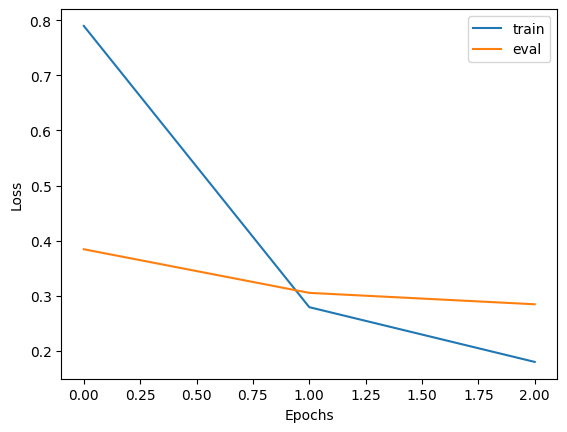

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

updating: content/albert-base-v2/final/ (stored 0%)
updating: content/albert-base-v2/final/tokenizer.json (deflated 75%)
updating: content/albert-base-v2/final/special_tokens_map.json (deflated 49%)
updating: content/albert-base-v2/final/model.safetensors (deflated 7%)
updating: content/albert-base-v2/final/training_args.bin (deflated 51%)
updating: content/albert-base-v2/final/spiece.model (deflated 49%)
updating: content/albert-base-v2/final/tokenizer_config.json (deflated 85%)
updating: content/albert-base-v2/final/config.json (deflated 51%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, "twmkn9/albert-base-v2-squad2")

In [ ]:
context = test['qa_pairs'][0][0]['context']
question = test['qa_pairs'][0][0]['question']
answer = test['qa_pairs'][0][0]['answers']['text'][0]

print(context)
print(question)
print(answer)
print(pipe.inference(question, context))

( 3 ) Anhaltspunkte dafür , dass der Teilwert der streitbefangenen Wiederbepflanzungsrechte zum 30. Juni 2011 unter deren Anschaffungskosten ( § 6 Abs. 1 Nr. 2 Satz 2 EStG ) gesunken war , sind weder vorgetragen noch ersichtlich .
Was ist der Name des erwähnten Gesetzes?
§ 6 Abs. 1 Nr. 2 Satz 2 EStG
{'score': 0.9983197450637817, 'start': 142, 'end': 171, 'answer': ' § 6 Abs. 1 Nr. 2 Satz 2 EStG'}


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:02<00:00, 50.74it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall    f1     exact_match    support
------------  -----------  --------  -----  -------------  ---------
GS            0.953        0.896     0.911  0.867          1294
LIT           0.917        0.443     0.534  0.232          155
INN           0.931        0.819     0.849  0.692          185
VS            0.822        0.690     0.715  0.536          69
UN            0.925        0.936     0.917  0.846          78
PER           0.955        0.942     0.941  0.892          158
LD            0.928        0.941     0.926  0.877          114
RS            0.937        0.206     0.282  0.075          667
VT            0.924        0.806     0.825  0.704          223
RR            0.989        0.995     0.991  0.984          187
EUN           0.920        0.739     0.779  0.590          100
ST            0.902        0.934     0.909  0.885          61
GRT           0.983        0.964     0.966  0.938          257
LDS           0.672        0.765     0.687  0.6

# GPT-2

In [ ]:
model_name = "openai-gpt2"

## Training

In [ ]:
model = ModelTrainer("dbmdz/german-gpt2", "dbmdz/german-gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

Some weights of GPT2ForQuestionAnswering were not initialized from the model checkpoint at dbmdz/german-gpt2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer.json:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__preprocess_function of <__main__.ModelTrainer object at 0x7a37daf6b940>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subseque

Map:   0%|          | 0/17200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,1.092000,0.464780
2,0.264000,0.357190


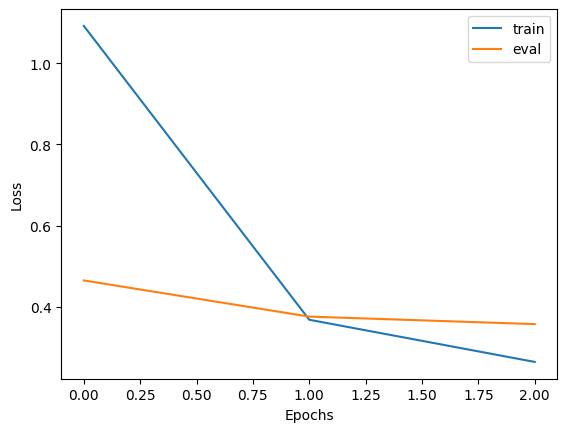

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/openai-gpt2/final/ (stored 0%)
  adding: content/openai-gpt2/final/model.safetensors (deflated 7%)
  adding: content/openai-gpt2/final/config.json (deflated 51%)
  adding: content/openai-gpt2/final/tokenizer_config.json (deflated 80%)
  adding: content/openai-gpt2/final/training_args.bin (deflated 51%)
  adding: content/openai-gpt2/final/added_tokens.json (stored 0%)
  adding: content/openai-gpt2/final/tokenizer.json (deflated 72%)
  adding: content/openai-gpt2/final/special_tokens_map.json (deflated 60%)
  adding: content/openai-gpt2/final/vocab.json (deflated 59%)
  adding: content/openai-gpt2/final/merges.txt (deflated 55%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, "dbmdz/german-gpt2")

In [ ]:
context = test['qa_pairs'][0][0]['context']
question = test['qa_pairs'][0][0]['question']
answer = test['qa_pairs'][0][0]['answers']['text'][0]

print(context)
print(question)
print(answer)
print(pipe.inference(question, context))

( 3 ) Anhaltspunkte dafür , dass der Teilwert der streitbefangenen Wiederbepflanzungsrechte zum 30. Juni 2011 unter deren Anschaffungskosten ( § 6 Abs. 1 Nr. 2 Satz 2 EStG ) gesunken war , sind weder vorgetragen noch ersichtlich .
Was ist der Name des erwähnten Gesetzes?
§ 6 Abs. 1 Nr. 2 Satz 2 EStG
{'score': 0.9849786162376404, 'start': 142, 'end': 171, 'answer': ' § 6 Abs. 1 Nr. 2 Satz 2 EStG'}


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [00:41<00:00, 77.11it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall    f1     exact_match    support
------------  -----------  --------  -----  -------------  ---------
GS            0.950        0.916     0.923  0.907          1294
LIT           0.900        0.567     0.628  0.381          155
INN           0.927        0.923     0.909  0.843          185
VS            0.837        0.743     0.753  0.652          69
UN            0.907        0.894     0.890  0.846          78
PER           0.876        0.888     0.869  0.816          158
LD            0.931        0.939     0.931  0.930          114
RS            0.964        0.483     0.572  0.178          667
VT            0.928        0.846     0.859  0.776          223
RR            0.981        0.992     0.982  0.968          187
EUN           0.921        0.791     0.818  0.680          100
ST            0.791        0.877     0.800  0.754          61
GRT           0.959        0.966     0.955  0.938          257
LDS           0.493        0.588     0.507  0.4

# GPT-Neo

In [ ]:
model_name = "gpt-neo-125m"

## Training

In [ ]:
model = ModelTrainer("EleutherAI/gpt-neo-125m", "EleutherAI/gpt-neo-125m")

Some weights of GPTNeoForQuestionAnswering were not initialized from the model checkpoint at EleutherAI/gpt-neo-125m and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/17200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,5.242300,6.160281
2,5.247600,5.191911


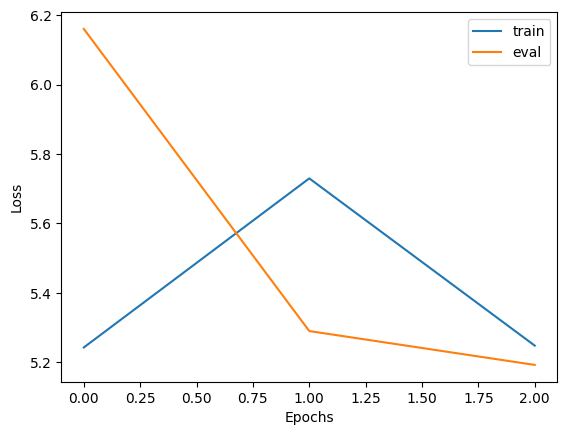

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

updating: content/gpt-neo-125m/final/ (stored 0%)
updating: content/gpt-neo-125m/final/model.safetensors (deflated 18%)
updating: content/gpt-neo-125m/final/tokenizer.json (deflated 72%)
updating: content/gpt-neo-125m/final/tokenizer_config.json (deflated 55%)
updating: content/gpt-neo-125m/final/vocab.json (deflated 59%)
updating: content/gpt-neo-125m/final/config.json (deflated 58%)
updating: content/gpt-neo-125m/final/merges.txt (deflated 53%)
updating: content/gpt-neo-125m/final/training_args.bin (deflated 51%)
updating: content/gpt-neo-125m/final/special_tokens_map.json (deflated 74%)
  adding: content/gpt-neo-125m/final/content/ (stored 0%)
  adding: content/gpt-neo-125m/final/content/gpt-neo-125m/ (stored 0%)
  adding: content/gpt-neo-125m/final/content/gpt-neo-125m/final/ (stored 0%)
  adding: content/gpt-neo-125m/final/content/gpt-neo-125m/final/model.safetensors (deflated 22%)
  adding: content/gpt-neo-125m/final/content/gpt-neo-125m/final/tokenizer.json (deflated 72%)
  addi

## Inference

In [ ]:
pipe = ModelPipe(model_name, "EleutherAI/gpt-neo-125m")

In [ ]:
context = test['qa_pairs'][0][0]['context']
question = test['qa_pairs'][0][0]['question']
answer = test['qa_pairs'][0][0]['answers']['text'][0]

print(context)
print(question)
print(answer)
print(pipe.inference(question, context))

( 3 ) Anhaltspunkte dafür , dass der Teilwert der streitbefangenen Wiederbepflanzungsrechte zum 30. Juni 2011 unter deren Anschaffungskosten ( § 6 Abs. 1 Nr. 2 Satz 2 EStG ) gesunken war , sind weder vorgetragen noch ersichtlich .
Was ist der Name des erwähnten Gesetzes?
§ 6 Abs. 1 Nr. 2 Satz 2 EStG
{'score': 0.00592260155826807, 'start': 199, 'end': 228, 'answer': ' vorgetragen noch ersichtlich'}


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:03<00:00, 50.11it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall    f1     exact_match    support
------------  -----------  --------  -----  -------------  ---------
GS            0.227        0.166     0.170  0.021          1294
LIT           0.193        0.060     0.084  0.000          155
INN           0.141        0.150     0.127  0.022          185
VS            0.201        0.139     0.151  0.014          69
UN            0.113        0.168     0.120  0.026          78
PER           0.056        0.145     0.074  0.019          158
LD            0.047        0.129     0.064  0.009          114
RS            0.250        0.079     0.110  0.000          667
VT            0.224        0.158     0.160  0.031          223
RR            0.905        0.893     0.891  0.840          187
EUN           0.256        0.108     0.130  0.010          100
ST            0.095        0.205     0.115  0.049          61
GRT           0.090        0.154     0.094  0.008          257
LDS           0.010        0.059     0.017  0.0

# T5

In [ ]:
model_name = "mt5-base"

## Training

In [ ]:
model = ModelTrainer("google/mt5-base", "google/mt5-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

Some weights of MT5ForQuestionAnswering were not initialized from the model checkpoint at google/mt5-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__preprocess_function of <__main__.ModelTrainer object at 0x7b10737e3e50>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subseque

Map:   0%|          | 0/17200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,4.174900,4.057227
2,2.299700,1.311959
3,1.208600,0.871811


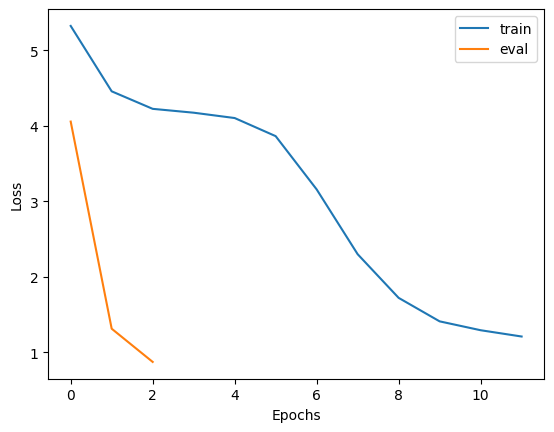

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/mt5-base/final/ (stored 0%)
  adding: content/mt5-base/final/model.safetensors (deflated 27%)
  adding: content/mt5-base/final/spiece.model (deflated 46%)
  adding: content/mt5-base/final/config.json (deflated 48%)
  adding: content/mt5-base/final/tokenizer_config.json (deflated 95%)
  adding: content/mt5-base/final/training_args.bin (deflated 51%)
  adding: content/mt5-base/final/tokenizer.json (deflated 76%)
  adding: content/mt5-base/final/special_tokens_map.json (deflated 73%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, "google/mt5-base")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
context = test['qa_pairs'][0][0]['context']
question = test['qa_pairs'][0][0]['question']
answer = test['qa_pairs'][0][0]['answers']['text'][0]

print(context)
print(question)
print(answer)
print(pipe.inference(question, context))

( 3 ) Anhaltspunkte dafür , dass der Teilwert der streitbefangenen Wiederbepflanzungsrechte zum 30. Juni 2011 unter deren Anschaffungskosten ( § 6 Abs. 1 Nr. 2 Satz 2 EStG ) gesunken war , sind weder vorgetragen noch ersichtlich .
Was ist der Name des erwähnten Gesetzes?
§ 6 Abs. 1 Nr. 2 Satz 2 EStG
{'score': 0.8339411616325378, 'start': 142, 'end': 171, 'answer': ' § 6 Abs. 1 Nr. 2 Satz 2 EStG'}


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [02:31<00:00, 20.87it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall    f1     exact_match    support
------------  -----------  --------  -----  -------------  ---------
GS            0.933        0.888     0.896  0.883          1294
LIT           0.759        0.457     0.534  0.239          155
INN           0.700        0.660     0.649  0.535          185
VS            0.762        0.685     0.689  0.580          69
UN            0.717        0.811     0.740  0.590          78
PER           0.567        0.707     0.598  0.443          158
LD            0.563        0.623     0.579  0.518          114
RS            0.703        0.272     0.341  0.106          667
VT            0.819        0.744     0.749  0.641          223
RR            0.939        0.939     0.930  0.872          187
EUN           0.806        0.680     0.707  0.590          100
ST            0.578        0.705     0.607  0.508          61
GRT           0.666        0.724     0.679  0.599          257
LDS           0.343        0.471     0.382  0.2

# XLNet

In [ ]:
model_name = "xlnet-base-cased"

## Training

In [ ]:
model = ModelTrainer("xlnet/xlnet-base-cased", "xlnet/xlnet-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__preprocess_function of <__main__.ModelTrainer object at 0x797f35ffd6c0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subseque

Map:   0%|          | 0/17200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,0.963800,0.470024
2,0.385200,0.286607


Epoch,Training Loss,Validation Loss
0,0.963800,0.470024
2,0.262300,0.269172


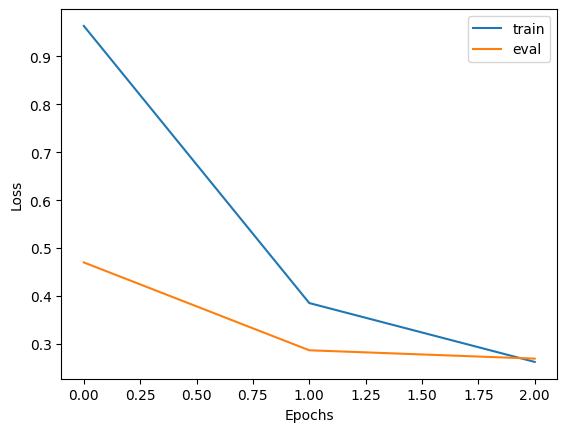

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/xlnet-base-cased/final/ (stored 0%)
  adding: content/xlnet-base-cased/final/model.safetensors (deflated 7%)
  adding: content/xlnet-base-cased/final/spiece.model (deflated 49%)
  adding: content/xlnet-base-cased/final/config.json (deflated 51%)
  adding: content/xlnet-base-cased/final/tokenizer_config.json (deflated 82%)
  adding: content/xlnet-base-cased/final/training_args.bin (deflated 51%)
  adding: content/xlnet-base-cased/final/tokenizer.json (deflated 75%)
  adding: content/xlnet-base-cased/final/special_tokens_map.json (deflated 52%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, "xlnet/xlnet-base-cased")

In [ ]:
context = test['qa_pairs'][0][0]['context']
question = test['qa_pairs'][0][0]['question']
answer = test['qa_pairs'][0][0]['answers']['text'][0]

print(context)
print(question)
print(answer)
print(pipe.inference(question, context))

In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [01:26<00:00, 36.61it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall    f1     exact_match    support
------------  -----------  --------  -----  -------------  ---------
GS            0.961        0.860     0.880  0.831          1294
LIT           0.928        0.345     0.418  0.226          155
INN           0.981        0.865     0.898  0.741          185
VS            0.786        0.550     0.581  0.391          69
UN            0.959        0.955     0.956  0.923          78
PER           0.912        0.934     0.915  0.873          158
LD            0.956        0.958     0.954  0.939          114
RS            0.975        0.199     0.270  0.088          667
VT            0.899        0.760     0.782  0.646          223
RR            0.805        0.773     0.783  0.733          187
EUN           0.901        0.658     0.701  0.530          100
ST            0.807        0.918     0.831  0.754          61
GRT           0.977        0.947     0.950  0.899          257
LDS           0.544        0.647     0.573  0.4

# BART

In [ ]:
model_name = "mbart-large-cc25"

## Training

In [ ]:
model = ModelTrainer("facebook/mbart-large-cc25", "facebook/mbart-large-cc25")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

Some weights of MBartForQuestionAnswering were not initialized from the model checkpoint at facebook/mbart-large-cc25 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__preprocess_function of <__main__.ModelTrainer object at 0x7c944641d5d0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subseque

Map:   0%|          | 0/17200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.224100,0.204392
2,0.113600,0.185032
3,0.049300,0.230771


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024, 'num_beams': 5, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024, 'num_beams': 5, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) 

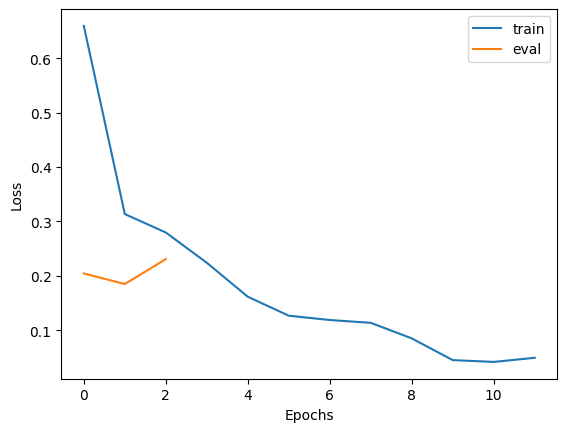

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024, 'num_beams': 5, 'forced_eos_token_id': 2}


  adding: content/mbart-large-cc25/final/ (stored 0%)
  adding: content/mbart-large-cc25/final/sentencepiece.bpe.model (deflated 49%)
  adding: content/mbart-large-cc25/final/tokenizer.json (deflated 76%)
  adding: content/mbart-large-cc25/final/special_tokens_map.json (deflated 57%)
  adding: content/mbart-large-cc25/final/model.safetensors (deflated 19%)
  adding: content/mbart-large-cc25/final/training_args.bin (deflated 51%)
  adding: content/mbart-large-cc25/final/tokenizer_config.json (deflated 90%)
  adding: content/mbart-large-cc25/final/config.json (deflated 59%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, "facebook/mbart-large-cc25")

In [ ]:
context = test['qa_pairs'][0][0]['context']
question = test['qa_pairs'][0][0]['question']
answer = test['qa_pairs'][0][0]['answers']['text'][0]

print(context)
print(question)
print(answer)
print(pipe.inference(question, context))

( 3 ) Anhaltspunkte dafür , dass der Teilwert der streitbefangenen Wiederbepflanzungsrechte zum 30. Juni 2011 unter deren Anschaffungskosten ( § 6 Abs. 1 Nr. 2 Satz 2 EStG ) gesunken war , sind weder vorgetragen noch ersichtlich .
Was ist der Name des erwähnten Gesetzes?
§ 6 Abs. 1 Nr. 2 Satz 2 EStG
{'score': 1.0, 'start': 143, 'end': 171, 'answer': '§ 6 Abs. 1 Nr. 2 Satz 2 EStG'}


In [ ]:
pipe.evaluate(test)

100%|██████████| 3167/3167 [02:00<00:00, 26.35it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall    f1     exact_match    support
------------  -----------  --------  -----  -------------  ---------
GS            0.958        0.907     0.915  0.910          1294
LIT           0.971        0.553     0.648  0.297          155
INN           0.994        0.969     0.976  0.951          185
VS            0.937        0.817     0.832  0.768          69
UN            0.949        0.944     0.946  0.936          78
PER           0.980        0.987     0.982  0.975          158
LD            0.982        0.991     0.985  0.974          114
RS            0.979        0.467     0.586  0.175          667
VT            0.951        0.897     0.908  0.830          223
RR            0.991        0.995     0.991  0.989          187
EUN           0.961        0.811     0.843  0.730          100
ST            0.984        0.975     0.978  0.967          61
GRT           0.981        0.985     0.982  0.969          257
LDS           0.824        0.824     0.824  0.8

https://huggingface.co/docs/transformers/tasks/question_answering